In [50]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten

import os
from tqdm import tqdm
from sklearn import preprocessing
import cv2
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Initiating Hyper Params

In [84]:
learning_rate = 0.001
im_size = 128
training_dir = '../inputs/train/'
testing_dir = '../inputs/test/'

# Utils
def process_image(file_dir, name):
    fname = '{fdir}{fname}'.format(fdir=file_dir, fname=name)
    x = cv2.imread(fname)
    return cv2.resize(x, (im_size, im_size))

## Inspecting train data set

In [85]:
# Training
df_train = pd.read_csv('../inputs/train.csv')
df_train.head()

,Image,Id
0,00022e1a.jpg,w_e15442c
1,000466c4.jpg,w_1287fbc
2,00087b01.jpg,w_da2efe0
3,001296d5.jpg,w_19e5482
4,0014cfdf.jpg,w_f22f3e3


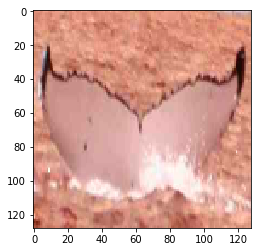

In [86]:
img = process_image(training_dir, df_train.Image[3])
plt.imshow(img)
plt.show()

In [87]:
# testing data
test_files = []
for root, dirs, files in os.walk("../inputs/test"):  
    for filename in files:
        test_files.append(filename)

# Data preparation

In [88]:
# Do we need to one-hot encode labels?
X_train = []
y_train = []
X_test = []

In [89]:
for file, label in tqdm(df_train.values):
    img = process_image(training_dir, file)
    X_train.append(img)
    y_train.append(label)

100%|██████████| 9850/9850 [00:53<00:00, 183.28it/s]


In [90]:
for file in tqdm(test_files):
    img = process_image(testing_dir, file)
    X_test.append(img)

100%|██████████| 15610/15610 [01:28<00:00, 175.71it/s]


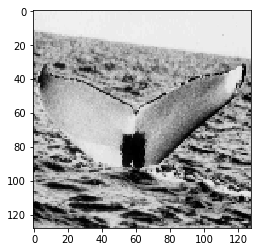

In [91]:
plt.imshow(X_test[4])
plt.show()

In [100]:
y_train_raw = np.array(y_train, np.str)
# print('checking train')
# print(X_train[0])
X_train_raw = np.array(X_train, np.float32) / 255
# print(np.array(X_test[0]))
# print('checking t4est')
# print(X_test[10])
X_test = np.array(X_test, np.float32) / 255

In [101]:
# Checking shapes
print(y_train_raw.shape)
print(X_train_raw.shape)
print(X_test.shape)

(9850,)
(9850, 128, 128, 3)
(15610, 128, 128, 3)


In [105]:
# Number of classes
num_classes = len(np.unique(y_train_raw))
print(num_classes)

4251


It is important to create a validation set so that you can gauge the performance of your model on independent data, unseen to the model in training. We do this by splitting the current training set (x_train_raw) and the corresponding labels (y_train_raw) so that we set aside 30 % of the data at random and put these in validation sets (X_valid and Y_valid).

This split needs to be improved so that it contains images from every class, with 120 separate classes some can not be represented and so the validation score is not informative.

## Model construction

In [81]:
# Create the base pre-trained model
# Can't download weights in the kernel
base_model = VGG19(
    weights='imagenet',
    #weights = 'None',
    include_top=False, input_shape=(im_size, im_size, 3))

# Add a new top layer
x = base_model.output
x = Flatten()(x)
print('checking num class ', num_class)
predictions = Dense(num_class, activation='softmax')(x)

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# First: train only the top layers (which were randomly initialized)
for layer in base_model.layers:
    layer.trainable = False

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]


base_model.summary()

checking num class  6895
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 90, 90, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 90, 90, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 90, 90, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 45, 45, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 45, 45, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 45, 45, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 22, 22, 128)   

## Model train

In [82]:
model.fit(train_X, train_y, epochs=1, validation_data=(valid_X, valid_y), verbose=1)

ValueError: Error when checking input: expected input_9 to have 4 dimensions, but got array with shape (6895, 1)